In [1]:
import sys

from PyMPDATA_examples.Arabas_and_Farhat_2020.options import OPTIONS

if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PyMPDATA-examples')

In [2]:
import os
import numpy as np
from scipy.interpolate import make_interp_spline
from matplotlib import pyplot, colors, colormaps, patches
from open_atmos_jupyter_utils import show_plot
# from PyMPDATA_examples.Magnuszewski_et_al_2025.common import OPTIONS
from PyMPDATA import Options

from PyMPDATA_examples.Magnuszewski_et_al_2025.asian_option import AsianArithmetic, Settings
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption
from PyMPDATA_examples.utils.financial_formulae import Black_Scholes_1973
import PyMPDATA_examples.utils.financial_formulae.asian_option as asian_analytic
from tqdm import tqdm
from PyMPDATA_examples.Magnuszewski_et_al_2025.monte_carlo import BSModel, FixedStrikeArithmeticAsianOption

In [34]:
# base_nx = 21
# base_ny = 31

mc_n_paths = 1000000
mc_seed = 42
mc_path_points = 1000

spot=100

SETTINGS = Settings(
    T=1,
    K=100,
    r=.05,
    sgma=.4,
    S_max=200,
    S_min=50,
)
variant = "call"

OPTIONS_mpdata_4 = Options(
        n_iters=4,
        nonoscillatory=True,
        non_zero_mu_coeff=True,
    )

OPTIONS_mpdata = Options(
        n_iters=2,
        nonoscillatory=True,
        non_zero_mu_coeff=True,
    )

OPTIONS_upwind = Options(
        n_iters=1,
        non_zero_mu_coeff=True,
    )


In [35]:
# global_sim_s = {}

In [36]:
# mc_model = BSModel(
#         T=1,
#         sigma=0.4,
#         r=0.05,
#         M=mc_path_points,
#         S0=spot,
#         seed=mc_seed
#     )
# arithmetic_option = FixedStrikeArithmeticAsianOption(1, spot, variant, mc_model, mc_n_paths)
# price_by_mc = arithmetic_option.price_by_mc()

In [37]:
def asian_mc_at_spot(spot):
    mc_model = BSModel(
        T=1,
        sigma=0.4,
        r=0.05,
        M=mc_path_points,
        S0=spot,
        seed=mc_seed
    )
    arithmetic_option = FixedStrikeArithmeticAsianOption(1, 100, variant, mc_model, mc_n_paths)
    return arithmetic_option.price_by_mc()

In [38]:
def calculate_l2_norm(array1, array2, ny, nt):
    nx = len(array1)
    return np.sqrt(np.sum((array1 - array2) ** 2) / (nx * ny * nt))

In [39]:
# price_by_mc

In [40]:
# price_by_mc=10.73305

In [41]:
scales = [1, 2, 4, 8]

In [42]:
resolution_1 = {
    'nt': 100,
    'nx': 5,
    'ny': 5,
}
errors_1 = {"MPDATA": [],
            "MPDATA_4": [],
             "UPWIND": []}

biggest_scale = max(scales)
dummy_resolution = {k: v * biggest_scale + 1 for k, v in resolution_1.items()}
dummy_simulation = AsianArithmetic(SETTINGS, **dummy_resolution, options=OPTIONS_mpdata, variant=variant)
most_discretized_domain = dummy_simulation.S.copy()

max_mc_domain = np.zeros_like(most_discretized_domain)
for idx, spot in tqdm(enumerate(most_discretized_domain), total=len(most_discretized_domain), desc="Calculating MC prices at discretized domain"):
    max_mc_domain[idx] = asian_mc_at_spot(spot)

courant_number_x=0.0011076872036787928
courant_y=0.049937578027465644
cfl_condition=0.051045265231144436


Calculating MC prices at discretized domain: 100%|██████████| 41/41 [16:44<00:00, 24.50s/it]


In [43]:
# save most_discretized_domain and max_mc_domain to a file
np.savez('mc_1m_1k.npz', most_discretized_domain=most_discretized_domain, max_mc_domain=max_mc_domain)

In [44]:
for scale in scales:
    resolution_scaled = {k: v * scale + 1 for k, v in resolution_1.items()}
    simulation_mpdata = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata, variant=variant)
    simulation_mpdata.step(simulation_mpdata.nt)
    simulation_price_mpdata = simulation_mpdata.solver.advectee.get()[:, 0]
    
    simulation_mpdata_4 = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata_4, variant=variant)
    simulation_mpdata_4.step(simulation_mpdata_4.nt)
    simulation_price_mpdata_4 = simulation_mpdata_4.solver.advectee.get()[:, 0]
    
    simulation_upwind = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_upwind, variant=variant)
    simulation_upwind.step(simulation_upwind.nt)
    simulation_price_upwind = simulation_upwind.solver.advectee.get()[:, 0]
    
    # for each s value 
    # arithmetic_by_mc = np.zeros_like(simulation_mpdata.S)
    # for idx, spot in enumerate(simulation_mpdata.S):
    #     arithmetic_by_mc[idx]  = asian_mc_at_spot(spot)
    # global_sim_s[scale] = simulation_mpdata.S.copy()
    arithmetic_by_mc = np.interp(simulation_mpdata.S, most_discretized_domain, max_mc_domain)
    errors_1["MPDATA"].append(calculate_l2_norm(simulation_price_mpdata, arithmetic_by_mc, simulation_mpdata.ny, simulation_mpdata.nt))
    errors_1["MPDATA_4"].append(calculate_l2_norm(simulation_price_mpdata_4, arithmetic_by_mc, simulation_mpdata_4.ny, simulation_mpdata_4.nt))
    errors_1["UPWIND"].append(calculate_l2_norm(simulation_price_upwind, arithmetic_by_mc, simulation_upwind.ny, simulation_upwind.nt))

courant_number_x=0.0012855698384159088
courant_y=0.049504950495049486
cfl_condition=0.05079052033346539
courant_number_x=0.0012855698384159088
courant_y=0.049504950495049486
cfl_condition=0.05079052033346539
courant_number_x=0.0012855698384159088
courant_y=0.049504950495049486
cfl_condition=0.05079052033346539
courant_number_x=0.0011843018992372095
courant_y=0.0497512437810945
cfl_condition=0.05093554568033171
courant_number_x=0.0011843018992372095
courant_y=0.0497512437810945
cfl_condition=0.05093554568033171
courant_number_x=0.0011843018992372095
courant_y=0.0497512437810945
cfl_condition=0.05093554568033171
courant_number_x=0.001133289121895321
courant_y=0.04987531172069823
cfl_condition=0.05100860084259355
courant_number_x=0.001133289121895321
courant_y=0.04987531172069823
cfl_condition=0.05100860084259355
courant_number_x=0.001133289121895321
courant_y=0.04987531172069823
cfl_condition=0.05100860084259355
courant_number_x=0.0011076872036787928
courant_y=0.049937578027465644
cfl_co

In [30]:
# resolution_2 = {
#     'nt': 2000,
#     'nx': 10,
#     'ny': 10,
# }
# results_2 = {"MPDATA": {},
#              "UPWIND": {}}
# for scale in scales:
#     resolution_scaled = {k: v * scale + 1 for k, v in resolution_2.items()}
#     simulation_mpdata = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata, variant=variant)
#     simulation_mpdata.step(simulation_mpdata.nt)
#     simulation_price_mpdata = simulation_mpdata.solver.advectee.get()[:, 0]
#     
#     simulation_upwind = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_upwind, variant=variant)
#     simulation_upwind.step(simulation_upwind.nt)
#     simulation_price_upwind = simulation_upwind.solver.advectee.get()[:, 0]
#     
#     results_2["MPDATA"][scale] = np.interp(spot, simulation_mpdata.S, simulation_price_mpdata)
#     results_2["UPWIND"][scale] = np.interp(spot, simulation_upwind.S, simulation_price_upwind)
# 
# print(results_2)
# errors_2 = {
#     "MPDATA": [abs(results_2["MPDATA"][scale] - price_by_mc) for scale in scales],
#     "UPWIND": [abs(results_2["UPWIND"][scale] - price_by_mc) for scale in scales]
# }


In [31]:
# resolution_3 = {
#     'nt': 2000,
#     'nx': 10,
#     'ny': 20,
# }
# results_3 = {"MPDATA": {},
#              "UPWIND": {}}
# for scale in scales:
#     resolution_scaled = {k: v * scale + 1 for k, v in resolution_3.items()}
#     simulation_mpdata = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_mpdata, variant=variant)
#     simulation_mpdata.step(simulation_mpdata.nt)
#     simulation_price_mpdata = simulation_mpdata.solver.advectee.get()[:, 0]
#     
#     simulation_upwind = AsianArithmetic(SETTINGS, **resolution_scaled, options=OPTIONS_upwind, variant=variant)
#     simulation_upwind.step(simulation_upwind.nt)
#     simulation_price_upwind = simulation_upwind.solver.advectee.get()[:, 0]
#     
#     results_3["MPDATA"][scale] = np.interp(spot, simulation_mpdata.S, simulation_price_mpdata)
#     results_3["UPWIND"][scale] = np.interp(spot, simulation_upwind.S, simulation_price_upwind)
# 
# print(results_3)
# errors_3 = {
#     "MPDATA": [abs(results_3["MPDATA"][scale] - price_by_mc) for scale in scales],
#     "UPWIND": [abs(results_3["UPWIND"][scale] - price_by_mc) for scale in scales]
# }


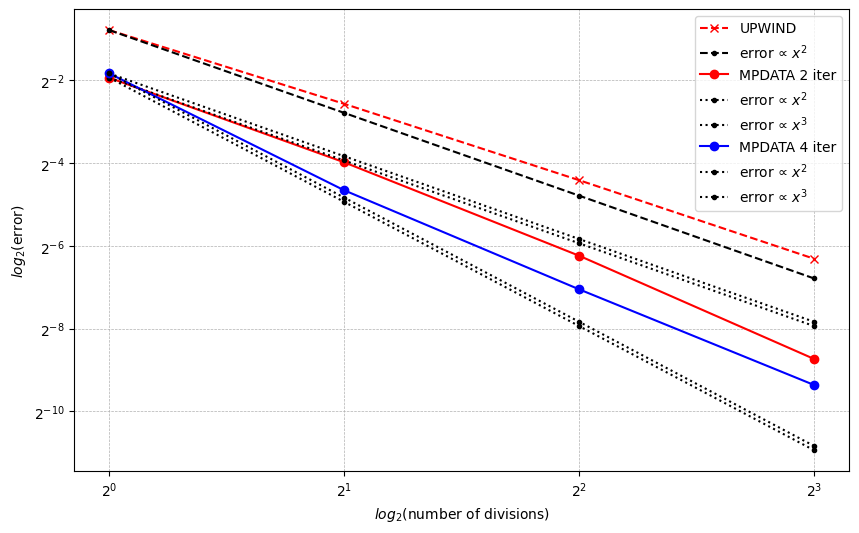

In [45]:
# simulate error decreasing like x^2, starting from first scale, first value of errors_1["MPDATA"]

simulated_errors_upwind = [errors_1["UPWIND"][0] / (scale ** 2) for scale in scales]
simulated_errors_mpdata_t2 = [errors_1["MPDATA"][0] / (scale ** 2) for scale in scales]
simulated_errors_mpdata = [errors_1["MPDATA"][0] / (scale ** 3) for scale in scales]

simulated_errors_mpdata_4_t2 = [errors_1["MPDATA_4"][0] / (scale ** 2) for scale in scales]
simulated_errors_mpdata_4 = [errors_1["MPDATA_4"][0] / (scale ** 3) for scale in scales]
# simulated_errors_mpdata4 = [errors_1["MPDATA_4"][0] / (scale ** 3) for scale in scales]

fig, ax = pyplot.subplots(figsize=(10, 6))
# ax.set_title('Convergence Analysis of Asian Arithmetic Option Pricing')
ax.set_xlabel(f'$log_2$(number of divisions)')
ax.set_ylabel(f'$log_2$(error)')
ax.set_yscale('log', base=2)
ax.set_xscale('log', base=2)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.plot(scales, errors_1["UPWIND"], marker='x', linestyle='--', color='r', label='UPWIND')
ax.plot(scales, simulated_errors_upwind, marker='.', linestyle='--', color='k', label='error ∝ $x^2$')
# ax.plot([10*x for x in scales], errors_2["UPWIND"], marker='x', linestyle='--', color='b', label='UPWIND C=0.005')
# ax.plot([10*x for x in scales], errors_3["UPWIND"], marker='x', linestyle='--', color='g', label='UPWIND C=0.01')

ax.plot(scales, errors_1["MPDATA"], marker='o', linestyle='-', color='r', label='MPDATA 2 iter')
ax.plot(scales, simulated_errors_mpdata_t2, marker='.', linestyle=':', color='k', label='error ∝ $x^2$')
ax.plot(scales, simulated_errors_mpdata, marker='.', linestyle=':', color='k', label='error ∝ $x^3$')

ax.plot(scales, errors_1["MPDATA_4"], marker='o', linestyle='-', color='b', label='MPDATA 4 iter')
ax.plot(scales, simulated_errors_mpdata_4_t2, marker='.', linestyle=':', color='k', label='error ∝ $x^2$')
ax.plot(scales, simulated_errors_mpdata_4, marker='.', linestyle=':', color='k', label='error ∝ $x^3$')

# ax.plot([10*x for x in scales], errors_2["MPDATA"], marker='o', linestyle='-', color='b', label='MPDATA C=0.005')
# ax.plot([10*x for x in scales], errors_3["MPDATA"], marker='o', linestyle='-', color='g', label='MPDATA C=0.01')
# ax.set_xticks([10*x for x in scales])
# ax.set_xticks([10*x for x in scales[::2]])
ax.legend()


In [46]:
errors_1

{'MPDATA': [0.2612317055511223,
  0.06337006284475517,
  0.013258473968370063,
  0.002354126298593921],
 'MPDATA_4': [0.28065852735841607,
  0.03966082851967339,
  0.007551607582401164,
  0.0015218903926132712],
 'UPWIND': [0.5801485758785443,
  0.16876376194650494,
  0.04698747437433893,
  0.012610722164236528]}